#### Load LLM

In [2]:
from dotenv import load_dotenv
import guidance
import os

load_dotenv()

api_key = os.getenv("api_key")
organization = os.getenv("organization")

gpt4 = guidance.llms.OpenAI(api_key=api_key, organization=organization, model="gpt-4")

#### Ground truth data from Sea Dataset

In [3]:
sea_ice_variables = [
    "geopotential_heights", 
    "relative_humidity", 
    "sea_level_pressure",  
    "zonal_wind_at_10_meters", 
    "meridional_wind_at_10_meters", 
    "sensible_plus_latent_heat_flux", 
    "total_precipitation", 
    "total_cloud_cover", 
    "total_cloud_water_path",  
    "surface_net_shortwave_flux", 
    "surface_net_longwave_flux", 
    "northern_hemisphere_sea_ice_extent",
]

treatment = "surface_net_longwave_flux"
outcome = "northern_hemisphere_sea_ice_extent"

# ground truth confounders to the relationship between surface_net_longwave_flux and northern_hemisphere_sea_ice_extent
ground_truth_confounders = ["total_precipitation"]
   
ground_truth_graph = {
    ("surface_net_longwave_flux", "northern_hemisphere_sea_ice_extent"), 
    
    ("geopotential_heights", "surface_net_longwave_flux"), 
    ("geopotential_heights", "relative_humidity"), 
    ("geopotential_heights", "sea_level_pressure"), 

    ("relative_humidity", "total_cloud_cover"), 
    ("relative_humidity", "total_cloud_water_path"),
    ("relative_humidity", "total_precipitation"), 
    ("relative_humidity", "surface_net_longwave_flux"),

    ("sea_level_pressure", "relative_humidity"), 
    ("sea_level_pressure", "geopotential_heights"), 
    ("sea_level_pressure", "zonal_wind_at_10_meters"), 
    ("sea_level_pressure", "northern_hemisphere_sea_ice_extent"), 
    ("sea_level_pressure", "sensible_plus_latent_heat_flux"), 
    ("sea_level_pressure", "meridional_wind_at_10_meters"),

    ("zonal_wind_at_10_meters", "northern_hemisphere_sea_ice_extent"),
    ("zonal_wind_at_10_meters", "sensible_plus_latent_heat_flux"), 
    
    ("meridional_wind_at_10_meters", "northern_hemisphere_sea_ice_extent"),
    ("meridional_wind_at_10_meters", "sensible_plus_latent_heat_flux"), 
   
    ("sensible_plus_latent_heat_flux", "northern_hemisphere_sea_ice_extent"), 
    ("sensible_plus_latent_heat_flux", "sea_level_pressure"), 
    ("sensible_plus_latent_heat_flux", "zonal_wind_at_10_meters"), 
    ("sensible_plus_latent_heat_flux", "meridional_wind_at_10_meters"), 
    ("sensible_plus_latent_heat_flux", "total_precipitation"), 
    ("sensible_plus_latent_heat_flux", "total_cloud_cover"), 
    ("sensible_plus_latent_heat_flux", "total_cloud_water_path"), 
    
    ("total_precipitation", "northern_hemisphere_sea_ice_extent"),
    ("total_precipitation", "relative_humidity"),
    ("total_precipitation", "sensible_plus_latent_heat_flux"),
    ("total_precipitation", "surface_net_longwave_flux"),
    ("total_precipitation", "total_cloud_cover"),
    ("total_precipitation", "total_cloud_water_path"),
   
    ("total_cloud_water_path", "total_precipitation"), 
    ("total_cloud_water_path", "sensible_plus_latent_heat_flux"), 
    ("total_cloud_water_path", "relative_humidity"), 
    ("total_cloud_water_path", "surface_net_longwave_flux"), 
    ("total_cloud_water_path", "surface_net_shortwave_flux"), 
    
    ("total_cloud_cover", "total_precipitation"),
    ("total_cloud_cover", "sensible_plus_latent_heat_flux"),
    ("total_cloud_cover", "relative_humidity"),
    ("total_cloud_cover", "surface_net_longwave_flux"),
    ("total_cloud_cover", "surface_net_shortwave_flux"), 
    
    ("surface_net_shortwave_flux", "northern_hemisphere_sea_ice_extent"),
    
    ("northern_hemisphere_sea_ice_extent", "sea_level_pressure"),
    ("northern_hemisphere_sea_ice_extent", "zonal_wind_at_10_meters"),
    ("northern_hemisphere_sea_ice_extent", "meridional_wind_at_10_meters"),
    ("northern_hemisphere_sea_ice_extent", "sensible_plus_latent_heat_flux"),
    ("northern_hemisphere_sea_ice_extent", "surface_net_shortwave_flux"),
    ("northern_hemisphere_sea_ice_extent", "surface_net_longwave_flux"),
    }

#### Select random dataset subset

In [4]:
import random 

random.seed(42)  # Set the random seed for reproducibility
subset_size = 7
selected_variables = random.sample(sea_ice_variables[:-2], subset_size)

selected_variables.append(treatment)
selected_variables.append(outcome)  

# grab the relationships that match the subset variables
ground_truth_subset = set()    
for a in selected_variables:
    for b in selected_variables:
        if a != b and (a, b) in ground_truth_graph:
            ground_truth_subset.add((a, b))



#### Show Ground Truth Subgraph

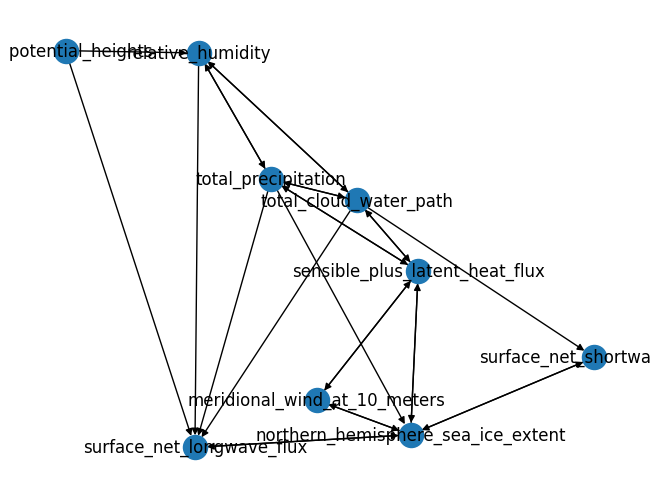

In [5]:
import networkx as nx
import matplotlib.pyplot as plt

ground_truth_subset_graph = nx.DiGraph()
ground_truth_subset_graph.add_nodes_from(selected_variables)
ground_truth_subset_graph.add_edges_from(ground_truth_subset)

nx.draw(ground_truth_subset_graph, with_labels=True)
plt.show()

#### Generate Synthetic Dataset

In [6]:
import pandas as pd
from dowhy import datasets

In [7]:

synthetic_data = dowhy.datasets.linear_dataset(
    beta=1,
    treatment_is_binary=False,
    num_common_causes=len(selected_variables)-2,
    num_samples=5000
)

df = synthetic_data['df']
df = df.rename(columns=dict(zip(df.columns, selected_variables)))
print(df.head())

ate = synthetic_data['ate']
print("ATE:", ate)

   relative_humidity  geopotential_heights  meridional_wind_at_10_meters  \
0           0.183726             -0.300130                     -2.067620   
1          -0.266644              1.155115                     -2.287895   
2          -0.335586              1.063956                      0.665373   
3           0.693922              0.383062                      0.293512   
4           0.604950             -1.427648                      0.501922   

   surface_net_shortwave_flux  total_precipitation  \
0                   -0.181017            -0.041810   
1                   -0.498560             2.006325   
2                   -1.753581            -0.252717   
3                   -1.025350             1.655094   
4                    0.225125             1.170208   

   sensible_plus_latent_heat_flux  total_cloud_water_path  \
0                        1.290566               -3.663243   
1                       -0.473393               -0.370831   
2                        0.396893  

# Modeler

In [8]:
import sys
sys.path.append("..")

from suggesters.model_suggester import ModelSuggester
modeler = ModelSuggester()

suggested_confounders = modeler.suggest_confounders(variables=selected_variables, llm=gpt4, treatment=treatment, outcome=outcome)

relationships_graph_1 = modeler.suggest_relationships(variables=selected_variables, llm=gpt4)

Stop program system You are a helpful assistant on causal reasoning. Your goal is to answer questions about cause and effect in arctic sea ice and atmosphere sciences in a factual and concise way. user Can changing northern_hemisphere_sea_ice_extent change geopotential_heights ?
 A. Yes
 B. No
 Let's think step-by-step to make sure that we have the right answer. Then provide your final answer within the tags, <answer>A/B</answer>. assistant Geopotential height is a measure used in meteorology to understand the altitude of an object, a particle, or a level above mean sea level in the atmosphere. It is influenced by temperature and pressure changes in the atmosphere. 

Changes in the northern hemisphere sea ice extent can influence atmospheric temperatures and pressure. When sea ice melts, it exposes the darker ocean surface, which absorbs more sunlight and heats the atmosphere, changing atmospheric temperature and pressure patterns. This in turn can influence geopotential heights.

So, the answer is:

<answer>A. Yes</answer>

['A. Yes']


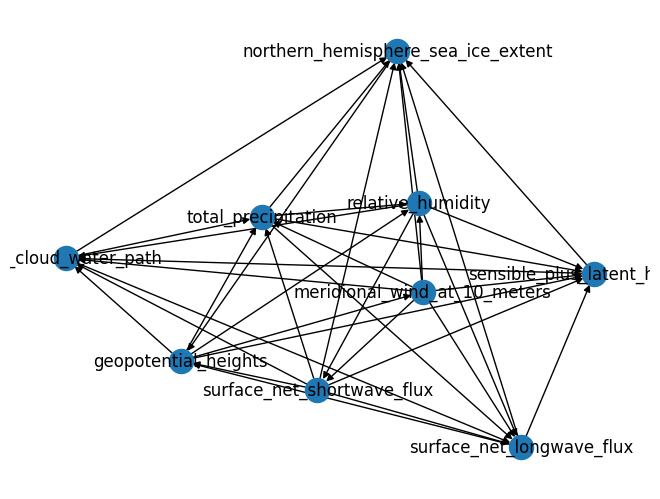

In [9]:
nx.draw(relationships_graph_1, with_labels=True)
plt.show()

# Modified Modeler: ToTModeler

In [10]:
import sys
sys.path.append('..')
from suggesters.tot_model_suggester import ToTModelSuggester
tot_modeler = ToTModelSuggester()

relationships_graph_2 = tot_modeler.suggest_relationships(variables=selected_variables, llm=gpt4)

Stop program system You are a helpful assistant on causal reasoning. Your goal is to answer questions about cause and effect in arctic sea ice and atmosphere sciences in a factual and concise way. user Can changing northern_hemisphere_sea_ice_extent change total_cloud_water_path ?
 In one sentence, make a compelling and factual argument for the relationship between northern_hemisphere_sea_ice_extent and total_cloud_water_path being true. And in another sentence, make a compelling argument for it being false. 
 If no arguemnt can be made for either option, then answer "I don't know" for that option.
 Show your work by explaining how you came to your conclusion. assistant True: Changes in the northern hemisphere sea ice extent can influence the total cloud water path because the reduction of sea ice can increase the evaporation of sea water, leading to a higher moisture content in the atmosphere and potentially more cloud formation.

False: However, the relationship between northern hemisphere sea ice extent and total cloud water path is not straightforward, as cloud formation is influenced by a multitude of factors including atmospheric temperature, pressure, and wind patterns, not just sea ice extent.

Explanation: The relationship between sea ice extent and cloud water path is complex and influenced by many factors. While it's true that less sea ice can lead to more evaporation and potentially more cloud formation, other atmospheric conditions also play a significant role in cloud formation. Therefore, a direct cause-effect relationship cannot be definitively established. user Now, critique the arguments for and against, and consider whether changing northern_hemisphere_sea_ice_extent changes total_cloud_water_path .
 A. Yes
 B. No
 Let's think step-by-step to make sure that we have the right answer. Then provide your final answer within the tags, <answer>A/B</answer>. assistant The argument for the relationship between northern hemisphere sea ice extent and total cloud water path is based on the principle that reduced sea ice can lead to increased evaporation, which in turn can contribute to cloud formation. This is a plausible argument as it is grounded in established scientific principles. However, it assumes a direct and singular relationship between sea ice extent and cloud water path, which may not be the case in reality.

The argument against the relationship acknowledges the complexity of cloud formation, stating that it is influenced by a multitude of factors such as atmospheric temperature, pressure, and wind patterns. This argument is also plausible as it takes into account the multifactorial nature of atmospheric phenomena.

Considering these arguments, it is reasonable to conclude that while changes in northern hemisphere sea ice extent may influence the total cloud water path, it is not the sole determinant. Other factors also play significant roles in cloud formation. Therefore, a change in northern hemisphere sea ice extent does not necessarily directly result in a change in total cloud water path.

<answer>B. No</answer>

['B. No']


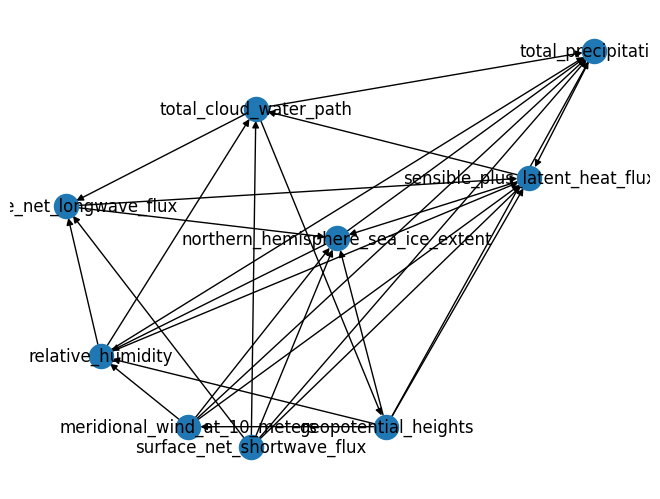

In [11]:
# Show Graph 
nx.draw(relationships_graph_2, with_labels=True)
plt.show()

# Identifier

In [12]:
import dowhy.causal_identifier as causal_identifier

causal_identifier.construct_backdoor_estimand(treatment, outcome, suggested_confounders)

{'estimand': Derivative(Expectation(n|relative_humidity,geopotential_heights,surface_net_shortwave_flux,total_precipitation,sensible_plus_latent_heat_flux,total_cloud_water_path), [s, u, r, f, a, c, e, _, n, e, t, _, l, o, n, g, w, a, v, e, _, f, l, u, x]),
 'assumptions': {'Unconfoundedness': 'If U→{s,u,r,f,a,c,e,_,n,e,t,_,l,o,n,g,w,a,v,e,_,f,l,u,x} and U→n then P(n|s,u,r,f,a,c,e,_,n,e,t,_,l,o,n,g,w,a,v,e,_,f,l,u,x,relative_humidity,geopotential_heights,surface_net_shortwave_flux,total_precipitation,sensible_plus_latent_heat_flux,total_cloud_water_path,U) = P(n|s,u,r,f,a,c,e,_,n,e,t,_,l,o,n,g,w,a,v,e,_,f,l,u,x,relative_humidity,geopotential_heights,surface_net_shortwave_flux,total_precipitation,sensible_plus_latent_heat_flux,total_cloud_water_path)'}}

In [13]:
from suggesters.identification_suggester import IdentificationSuggester 
identifier = IdentificationSuggester()

estimand = identifier.suggest_estimand(llm=gpt4,  confounders=suggested_confounders, treatment=treatment, outcome=outcome)

Stop program system You are a helpful assistant on causal reasoning and arctic sea ice and atmosphere sciences. Your goal is to answer questions factually and concisely about whether and how a causal effect can be estimated using your domain knowledge on artic sea ice and atmosphere sciences. user This variable is a potential confounder. If it were to be conditioned on, would it unbias the surface_net_longwave_flux -> northern_hemisphere_sea_ice_extent causal effect estimation?
 A. Yes
 B. No
 Let's think step-by-step to make sure that we have the right answer. Keep your argument and references to no more than one paragraph, otherwise you lose points, and wrap it within the tags, <explanation>...</explanation>. Then provide your final answer within the tags, <answer>A/B</answer>. assistant <explanation>Whether a variable is a confounder depends on its relationship with both the exposure (in this case, surface_net_longwave_flux) and the outcome (northern_hemisphere_sea_ice_extent). A confounder is a variable that is a common cause of both the exposure and outcome. If this variable is indeed a confounder, conditioning on it would help to control for its effect and thus reduce bias in the estimated causal effect of surface_net_longwave_flux on northern_hemisphere_sea_ice_extent. However, it's important to note that this assumes no other unmeasured confounding and that the variable is measured without error.</explanation>

<answer>A</answer>

In [14]:
print(estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
                                     d                                        
────────────────────────────────────────────────────────────────────────────(E
d[s  u  r  f  a  c  e  _  n  e  t  _  l  o  n  g  w  a  v  e  _  f  l  u  x]  

                                                                              
[n|relative_humidity,geopotential_heights,surface_net_shortwave_flux,total_pre
                                                                              

                                                                  
cipitation,sensible_plus_latent_heat_flux,total_cloud_water_path])
                                                                  
Estimand assumption 1, Unconfoundedness: If U→{s,u,r,f,a,c,e,_,n,e,t,_,l,o,n,g,w,a,v,e,_,f,l,u,x} and U→n then P(n|s,u,r,f,a,c,e,_,n,e,t,_,l,o,n,g,w,a,v,e,_,f,l,u,x,relative_humidity,geopotential_heights,surface_ne

# Validator

In [17]:
from suggesters.validation_suggester import ValidationSuggester 
validator = ValidationSuggester()

#### Critique graph

In [18]:
critiqued_relationships_graph_1 = validator.critique_graph(graph=relationships_graph_1, llm=gpt4)
critiqued_relationships_graph_2 = validator.critique_graph(graph=relationships_graph_2, llm=gpt4)

Stop program system You are a helpful assistant on causal reasoning. Your goal is to factually and concisely answer questions about cause and effect relationships using your domain knowledge on artic sea ice and atmosphere sciences. user Analyze the output from an AI assistant. Is the final answer B consistent with the reasoning provided by the assistant?
 
 Question
 Which cause and effect relationship is more likely?
 A. northern_hemisphere_sea_ice_extent causes total_precipitation ?
 B. total_precipitation causes northern_hemisphere_sea_ice_extent ?
 C. Neither. No causal relationship exists. 
 Let's think step-by-step to make sure that we have the right answer. Keep your argument to no more than one paragraph, otherwise you lose points, and wrap it within the tags, <explanation>...</explanation>. Then provide your final answer within the tags, <answer>A/B/C</answer>.
 
 AI Assistant Explanation
 The cause and effect relationship between northern hemisphere sea ice extent and total precipitation is complex and interconnected. However, it is more likely that total precipitation affects the northern hemisphere sea ice extent rather than the other way around. Precipitation, particularly in the form of snow, can contribute to the growth and preservation of sea ice by providing an insulating layer that reduces heat exchange between the ocean and the atmosphere. Meanwhile, the extent of sea ice can influence local weather patterns, but it does not directly cause changes in total precipitation on a global scale. 
 
 Critique the AI Assistant's argument by providing your own individual version of the argument. Provide your explanations within the tags, <explanation>...</explanation> and answer your final answer to the question within the tags, <answer>A/B/C</answer>. assistant <explanation>The AI assistant's reasoning is sound and consistent with the final answer. The relationship between total precipitation and northern hemisphere sea ice extent is indeed complex, but the assistant correctly identifies that total precipitation is more likely to cause changes in sea ice extent. Precipitation, especially snow, can add to the volume of sea ice and provide an insulating layer that reduces heat exchange between the ocean and the atmosphere, thus affecting the extent of sea ice. On the other hand, while sea ice extent can influence local weather patterns, it does not have a direct, large-scale impact on total global precipitation. Therefore, the cause and effect relationship is more likely to be from total precipitation to northern hemisphere sea ice extent.</explanation>

<answer>B</answer>

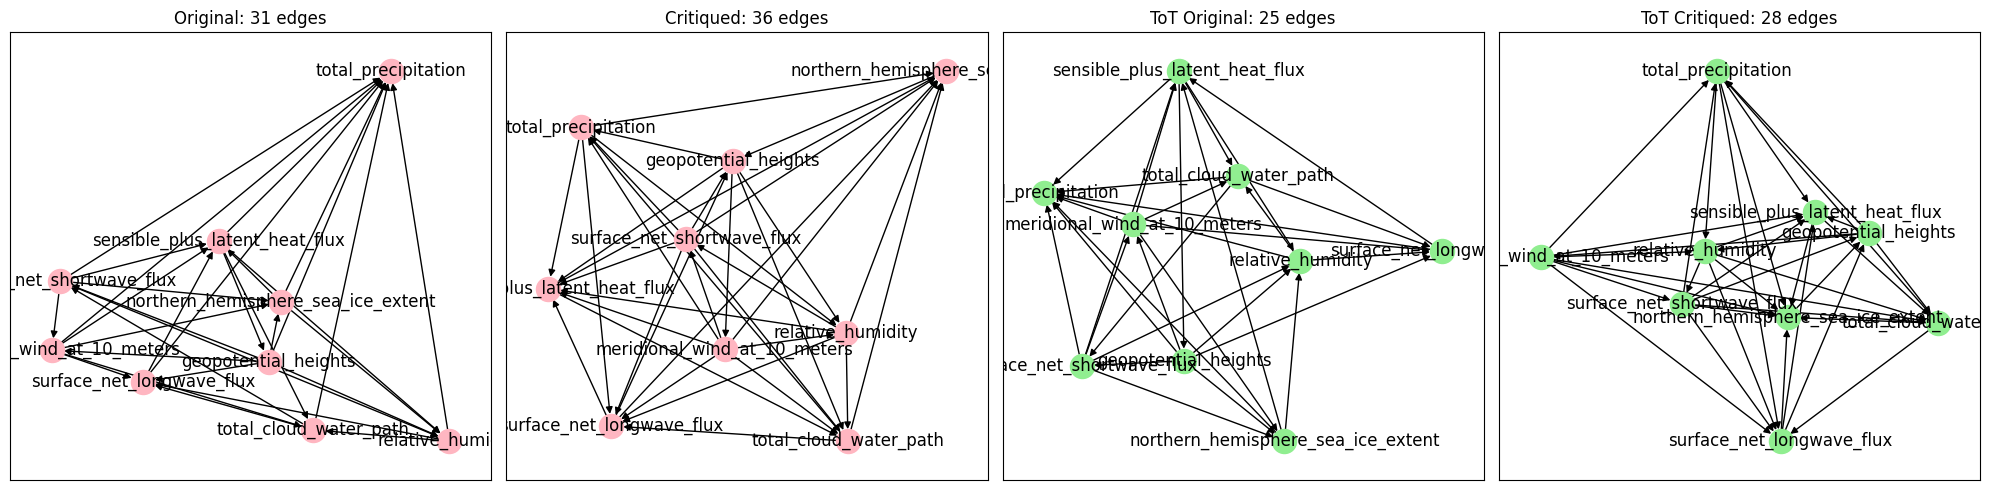

In [19]:
pos_1 = nx.spring_layout(relationships_graph_1, seed=42)
pos_2 = nx.spring_layout(critiqued_relationships_graph_1[1], seed=42)
pos_3 = nx.spring_layout(relationships_graph_2, seed=42)
pos_4 = nx.spring_layout(critiqued_relationships_graph_2[1], seed=42)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 5))

nx.draw_networkx(relationships_graph_1, pos_1, ax=ax1, with_labels=True, node_color='lightpink')
nx.draw_networkx(critiqued_relationships_graph_1[1], pos_2, ax=ax2, with_labels=True, node_color='lightpink')
nx.draw_networkx(relationships_graph_1, pos_3, ax=ax3, with_labels=True, node_color='lightgreen')
nx.draw_networkx(critiqued_relationships_graph_1[1], pos_4, ax=ax4, with_labels=True, node_color='lightgreen')

ax1.set_title(f'Original: {len(list(relationships_graph_1.edges))} edges')
ax2.set_title(f"Critiqued: {len(list(critiqued_relationships_graph_1[1].edges))} edges")
ax3.set_title(f"ToT Original: {len(list(relationships_graph_2.edges))} edges")
ax4.set_title(f"ToT Critiqued: {len(list(critiqued_relationships_graph_2[1].edges))} edges")

fig.tight_layout()
plt.show()

#### Suggest Lantent Confounders and Negative Controls

In [24]:
suggested_latent_confounders = validator.suggest_latent_confounders(llm=gpt4, treatment=treatment, outcome=outcome)

suggested_negative_controls = validator.suggest_negative_controls(variables=selected_variables, llm=gpt4, treatment=treatment, outcome=outcome)

Stop program system You are a helpful assistant on causal reasoning. Your goal is to answer questions about cause and effect in arctic sea ice and atmosphere sciences in a factual and concise way. user In a causal observational study of arctic sea ice and atmosphere science where we wish to measure the causal effect of surface_net_longwave_flux on northern_hemisphere_sea_ice_extent , we want to identify whether total_cloud_water_path is a negative control where we might expect to see zero treatment effect. Is total_cloud_water_path a likely negative control?
 A. Yes
 B. No
 Let's think step-by-step to make sure that we have the right answer. Provide your explanations within the tags, <explanation>...</explanation> and confounders within the tags, <answer>A/B</answer>. Explanations should be specific and not excede one sentence, otherwise you lose points. assistant <answer>B. No</answer>
<explanation>Total cloud water path can affect both the surface net longwave flux and the northern hemisphere sea ice extent, making it a potential confounder rather than a negative control.</explanation>

In [25]:
if suggested_latent_confounders:
    print("Suggested Latent Confounders")
    for confounder in suggested_latent_confounders:
        print(f"- {confounder}")

Suggested Latent Confounders
- Atmospheric temperature
- Solar radiation
- Cloud cover
- Sea water temperature
- Wind patterns


In [27]:
if suggested_negative_controls[0]:
    print("Suggested Negative Controls")
    # for suggested_negative_control in suggested_negative_controls:
    #     print(f"{suggested_negative_control}")
    print(f"{suggested_negative_controls[0]}")
